In [49]:
import cv2, imageio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

In [50]:
def GaussianBlur(src, ksize, sigmaX, sigmaY):
    '''
    INPUT:
    src: input image
    ksize: Gaussian kernel size, tuple or intger
    sigmaX: Gaussian kernel standard deviation in X direction 
    sigmaY: Gaussian kernel standard deviation in X direction
    
    OUTPUT:
    dst: return image 
    '''
    if type(ksize) == int:
        ksize = (ksize, ksize)
    elif type(ksize) == tuple:
        ksize = ksize

    ksize_ = ksize[0]
    pad = ksize_ // 2

    def gaussian_func(x, y, sigmaX, sigmaY):
        return 1 / (2 * np.pi * sigmaX * sigmaY) * np.exp(-0.5 * (x**2 / sigmaX**2 + y**2 / sigmaY**2))
    
    def conv2d(src, kernel):
        '''
        INPUT:
        src: input image
        kernel: convolution kernel
        
        OUTPUT:
        dst: return image 
        '''
        H, W, C = src.shape
        kernel_size = kernel.shape[0]
        pad = kernel_size // 2

        dst = np.zeros((H, W, C)) 
        src = np.pad(src, ((pad, pad), (pad, pad), (0, 0)), 'edge')

        for r in range(0, H):
            for c in range(0, W):
                for ch in range(C):
                    dst[r, c, ch] = (np.sum(src[r:r+kernel_size, c:c+kernel_size, ch] * kernel)).astype(np.uint8)
        return np.uint8(dst)
        pass

    kernel = np.zeros(ksize)
    for i in range(-(ksize[0]//2), ksize[0]//2+1):
        for j in range(-(ksize[1]//2), ksize[1]//2+1):
            kernel[i+ksize[0]//2, j+ksize[0]//2] = gaussian_func(i, j, sigmaX, sigmaY)    
    kernel /= np.sum(kernel)

    dst = conv2d(src, kernel)
    return dst
    pass

def medianBlur(src, ksize):
    '''
    INPUT:
    src: input image
    ksize: kernel size, tuple or intger
    
    OUTPUT:
    dst: return image 
    '''
    if type(ksize) == int:
        ksize = (ksize, ksize)
    elif type(ksize) == tuple:
        ksize = ksize

    H, W, C = src.shape

    kernel_size = ksize[0]
    pad = ksize[0] // 2

    dst = np.zeros((H, W, C)) 
    src = np.pad(src, ((pad, pad), (pad, pad), (0, 0)), 'edge')

    for r in range(0, H):
        for c in range(0, W):
            for ch in range(C):
                foo = src[r:r+kernel_size, c:c+kernel_size, ch]
                dst[r, c, ch] = (np.median(foo.reshape(-1))).astype(np.uint8)
    return np.uint8(dst)
    pass

def bilateralFilter(src, d, sigmaColor, sigmaSpace):
    '''
    INPUT:
    src: input image
    d: 	Diameter of each pixel neighborhood that is used during filtering. 
    sigmaColor: Filter sigma in the color space
    sigmaSpace: Filter sigma in the coordinate space.
    
    OUTPUT:
    dst: return image
    '''
    def color_func(color, sigmaColor):
        return (1 / (2 * np.pi * sigmaColor**2)**0.5) * np.e ** (-0.5 * (color**2) / (sigmaColor**2))

    def space_func(x, y, sigmaSpace):    
        return (1 / (2 * np.pi * sigmaSpace**2)) * np.e ** (-0.5 * (x**2 / sigmaSpace**2 + y**2 / sigmaSpace**2))
    
    def get_bilateral_filter_res(x, y, sigmaColor, sigmaSpace):
        delta = src_pad[x:x+d, y:y+d] - src_gray[x,y]
        color_kernel = np.zeros((d, d))
        space_kernel = np.zeros((d, d))
        kernel = np.zeros((d, d))

        for i in range(d):
            for j in range(d):
                color_kernel[i, j] = color_func(delta[i, j], sigmaColor)
                space_kernel[i, j] = space_func(i - d//2 - 1, j - d//2 - 1, sigmaSpace)
        kernel = color_kernel * space_kernel
        kernel /= np.sum(kernel)

        pick = src_pad[x:x+d, y:y+d]
        foo = pick * kernel
        return foo.sum()

    H, W, C = src.shape
    ksize =  2 * np.uint8(d) + 1
    pad = d
    src_gray = src.sum(axis=2) / 3
    src_pad = np.pad(src_gray, ((pad, pad), (pad, pad)), 'edge')
    dst = np.zeros((H, W))

    for i in range(0, H):
        for j in range(0, W):
            dst[i, j] = get_bilateral_filter_res(i, j, sigmaColor, sigmaSpace)

    return dst[:, :, np.newaxis].repeat(3, axis=2).astype(np.uint8)
    pass

d:\Anaconda\envs\cv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """
d:\Anaconda\envs\cv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
d:\Anaconda\envs\cv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


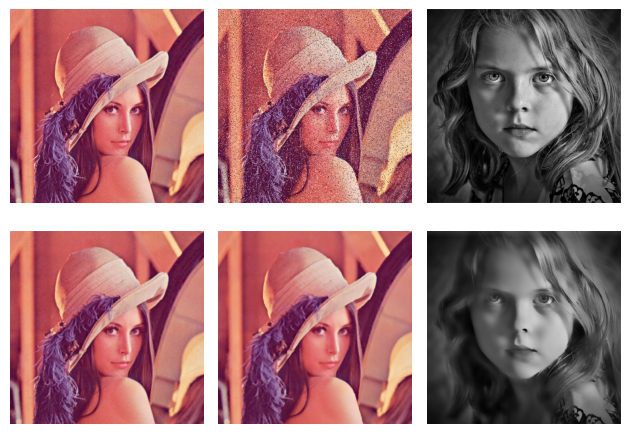

In [51]:
ga_lena_path = 'data/gaussian_lena.png'
sp_lena_path = 'data/sp_lena.png'
bi_girl_path = 'data/bilateral.jpg'

ga_lena = np.array(imageio.imread(ga_lena_path))
sp_lena = np.array(imageio.imread(sp_lena_path))
bi_girl = np.array(imageio.imread(bi_girl_path))


filter_ga_lena = GaussianBlur(ga_lena, (3, 3), sigmaX=1.0, sigmaY=1.0)
filter_sp_lena = medianBlur(sp_lena, ksize=5)
filter_bi_girl = bilateralFilter(bi_girl, d=25, sigmaColor=40, sigmaSpace=40)

ax = plt.subplot(231)
ax.axis('off')
ax.imshow(ga_lena)

ax = plt.subplot(232)
ax.axis('off')
ax.imshow(sp_lena)

ax = plt.subplot(233)
ax.axis('off')
ax.imshow(bi_girl)

ax = plt.subplot(234)
ax.axis('off')  
ax.imshow(filter_ga_lena)

ax = plt.subplot(235)
ax.axis('off')
ax.imshow(filter_sp_lena)

ax = plt.subplot(236)
ax.axis('off')
ax.imshow(filter_bi_girl)

plt.tight_layout()
plt.show()

In [52]:
def project_and_show(model_path, fx, fy):
    '''
    Project the 3D model using perspective projection and show it in a 2D plane.
    INPUT:
    model_path: string, path of 3D model
    fx: focal length in X direction
    fy: focal length in Y direction
    
    OUTPUT:
    None
    '''
    pcd_load = o3d.io.read_point_cloud(model_path)
    colors = np.asarray(pcd_load.colors)
    points_3d = np.asarray(pcd_load.points)
    points_3d = np.pad(points_3d, ((0, 0), (0, 1)), mode='constant', constant_values=1)
    points_3d[:, 2] += 1

    intrinsics = np.array([[fx, 0, 0, 0], [0, fy, 0, 0], [0, 0, 1, 0]])
    points_2d = np.dot(intrinsics, points_3d.T).T
    points_2d = points_2d[:, :2] / points_2d[:, 2:3]

    plt.scatter(points_2d.T[0], points_2d.T[1], s=1)
    ax = plt.gca()
    ax.set_aspect(1)
    plt.show()
    pass

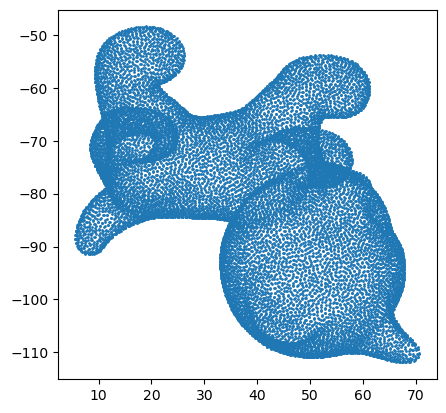

In [53]:
model_path, fx, fy = 'data/cat.ply', 572.4114, 573.57043
project_and_show(model_path, fx, fy)